In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BUandDU').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 04:32:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#BU: Predict what individual values as happiness based on demographic attribute

In [3]:
#DU
#Read in and display the data in dataset
df_demog=spark.read.csv('BDAS_Iteration_Dataset/demographic.csv', header=True, inferSchema=True)
df_happy=spark.read.csv('BDAS_Iteration_Dataset/cleaned_hm.csv', header=True, inferSchema=True)
df_demog.show()
df_happy.show()

+---+----+-------+------+--------+----------+
|wid| age|country|gender| marital|parenthood|
+---+----+-------+------+--------+----------+
|  1|37.0|    USA|     m| married|         y|
|  2|29.0|    IND|     m| married|         y|
|  3|  25|    IND|     m|  single|         n|
|  4|  32|    USA|     m| married|         y|
|  5|  29|    USA|     m| married|         y|
|  6|  35|    IND|     m| married|         y|
|  7|  34|    USA|     m| married|         y|
|  8|  29|    VNM|     m|  single|         n|
|  9|  61|    USA|     f| married|         y|
| 10|  27|    USA|     m|  single|         n|
| 11|45.0|    USA|     m|divorced|         n|
| 12|  25|    USA|     f|  single|         n|
| 13|45.0|    IND|     m| married|         y|
| 14|25.0|    IND|     m| married|         y|
| 15|  27|    USA|     m| married|         y|
| 16|35.0|    USA|     m|  single|         n|
| 17|30.0|    USA|     m|  single|         n|
| 18|  30|    USA|     m|  single|         n|
| 19|  29|    USA|     m| married|

In [4]:
df_demog.printSchema()
df_happy.printSchema()

root
 |-- wid: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- country: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- parenthood: string (nullable = true)

root
 |-- hmid: string (nullable = true)
 |-- wid: string (nullable = true)
 |-- reflection_period: string (nullable = true)
 |-- original_hm: string (nullable = true)
 |-- cleaned_hm: string (nullable = true)
 |-- modified: string (nullable = true)
 |-- num_sentence: string (nullable = true)
 |-- ground_truth_category: string (nullable = true)
 |-- predicted_category: string (nullable = true)



+----+-----+
| age|count|
+----+-----+
|  26|  355|
|  25|  353|
|  27|  335|
|  30|  318|
|  29|  317|
|  24|  302|
|  28|  300|
|  31|  282|
|  32|  273|
|  23|  264|
|26.0|  259|
|27.0|  258|
|25.0|  249|
|28.0|  246|
|29.0|  238|
|  34|  235|
|23.0|  225|
|  22|  225|
|30.0|  224|
|  33|  215|
+----+-----+
only showing top 20 rows



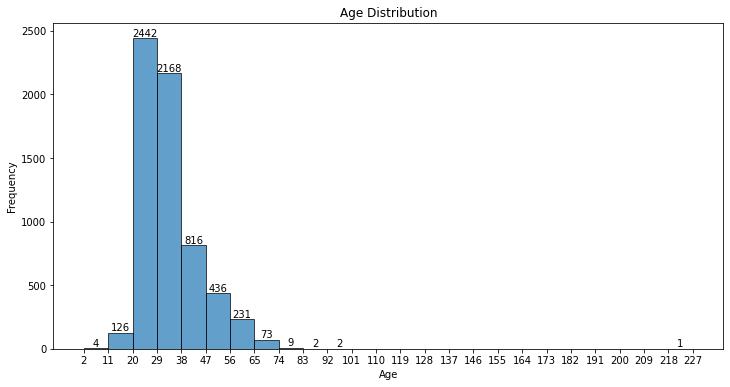

In [5]:
# Investigate each focused attribute with 'Group by' 

# Age
age_grouped_df = df_demog.groupBy('age')
result_df = age_grouped_df.count()
sorted_result_df = result_df.orderBy('count', ascending=False)
sorted_result_df.show()

#Data Visualizing

import matplotlib.pyplot as plt

# Filter out None and non-string values from the 'age' column
age_data = df_demog.filter(df_demog['age'].isNotNull() & (df_demog['age'] != '')).select('age').rdd.flatMap(lambda x: x).collect()

# Convert the 'age' values to integers for plotting
age_data = [int(age) for age in age_data if age.isdigit()]

# Create a histogram
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(age_data, bins=25, edgecolor='k', alpha=0.7)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

# Customize x-tick labels to display age values
plt.xticks(bins, [str(int(b)) for b in bins])

# Add count labels to each bar
for count, patch in zip(n, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)), ha='center', va='bottom')

# Display the plot
plt.show()

+-------+-----+
|country|count|
+-------+-----+
|    USA| 9274|
|    IND|  964|
|   null|   73|
|    CAN|   66|
|    VEN|   54|
|    GBR|   48|
|    PHL|   32|
|    MEX|   22|
|    BRA|   14|
|    AUS|   14|
|    NGA|   12|
|    ITA|   11|
|    FRA|   10|
|    GRC|    9|
|    TUR|    8|
|    PRT|    8|
|    NZL|    8|
|    DEU|    8|
|    JAM|    7|
|    ZAF|    7|
+-------+-----+
only showing top 20 rows



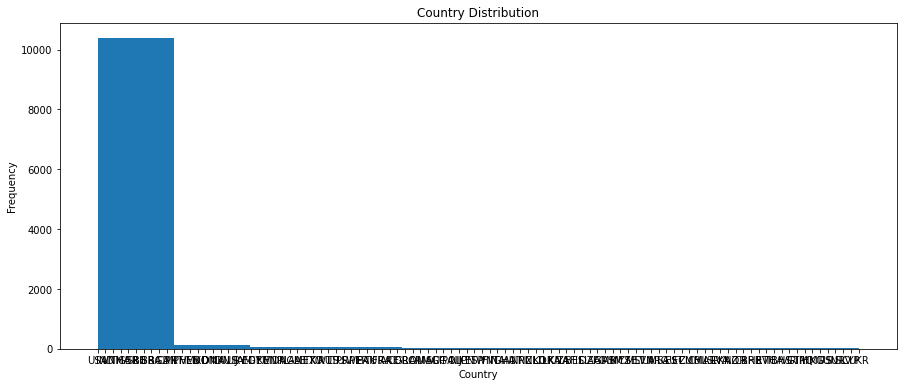

In [6]:
# Country
country_grouped_df = df_demog.groupBy('country')
result_df = country_grouped_df.count()
country_df = result_df.orderBy('count', ascending=False)
country_df.show()

country_data = df_demog.filter(df_demog['country'].isNotNull() & (df_demog['country'] != '')).select('country').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(15, 6))
plt.hist(country_data)

plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Country Distribution')

plt.show()

+------+-----+
|gender|count|
+------+-----+
|     f| 5445|
|     m| 5311|
|     o|   56|
|  null|   32|
+------+-----+



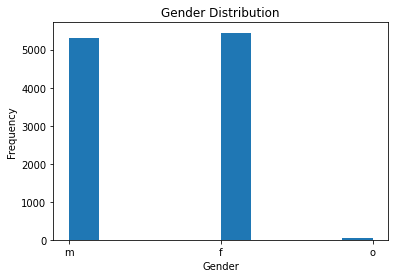

In [7]:
# Gender
gender_grouped_df = df_demog.groupBy('gender')
result_df = gender_grouped_df.count()
gender_df = result_df.orderBy('count', ascending=False)
gender_df.show()

gender_data = df_demog.filter(df_demog['gender'].isNotNull() & (df_demog['gender'] != '')).select('gender').rdd.flatMap(lambda x: x).collect()

plt.hist(gender_data)

plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution')

plt.show()

+---------+-----+
|  marital|count|
+---------+-----+
|separated|  102|
|     null|   57|
| divorced|  565|
|  married| 4371|
|   single| 5678|
|  widowed|   71|
+---------+-----+



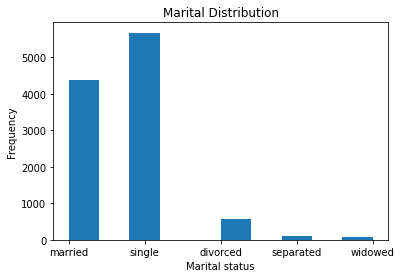

In [8]:
# Marital status
marital_grouped_df = df_demog.groupBy('marital')
marital_df = marital_grouped_df.count()
marital_df.show()

marital_data = df_demog.filter(df_demog['marital'].isNotNull() & (df_demog['marital'] != '')).select('marital').rdd.flatMap(lambda x: x).collect()

plt.hist(marital_data)

plt.xlabel('Marital status')
plt.ylabel('Frequency')
plt.title('Marital Distribution')

plt.show()

+----------+-----+
|parenthood|count|
+----------+-----+
|      null|   31|
|         n| 6448|
|         y| 4365|
+----------+-----+



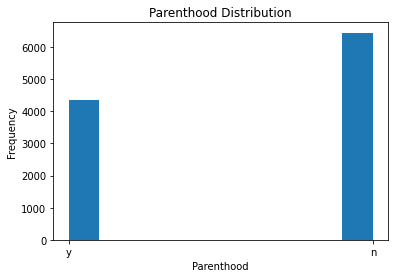

In [9]:
# Parenthood
parenthood_grouped_df = df_demog.groupBy('parenthood')
parenthood_df = parenthood_grouped_df.count()
parenthood_df.show()

parenthood_data = df_demog.filter(df_demog['parenthood'].isNotNull() & (df_demog['parenthood'] != '')).select('parenthood').rdd.flatMap(lambda x: x).collect()

plt.hist(parenthood_data)

plt.xlabel('Parenthood')
plt.ylabel('Frequency')
plt.title('Parenthood Distribution')

plt.show()

+--------------------+-----+
|  predicted_category|count|
+--------------------+-----+
| and the building...|    4|
| running to the f...|    4|
|             bonding|10495|
|                   7|   10|
|                  so|    1|
| and I had no ide...|    5|
|        went to work|    4|
| making someone e...|    1|
| including him an...|    1|
| but I know that ...|    1|
| Hurray!!! I got ...|    1|
| the result pdf d...|    1|
| provocative pose...|    2|
| you can shop 1 y...|    1|
|         """Long ago|    1|
| fresher and clos...|    1|
| ""you have a nic...|    1|
|                   3|   26|
| I appreciate eve...|    1|
| get too hung up ...|    1|
+--------------------+-----+
only showing top 20 rows



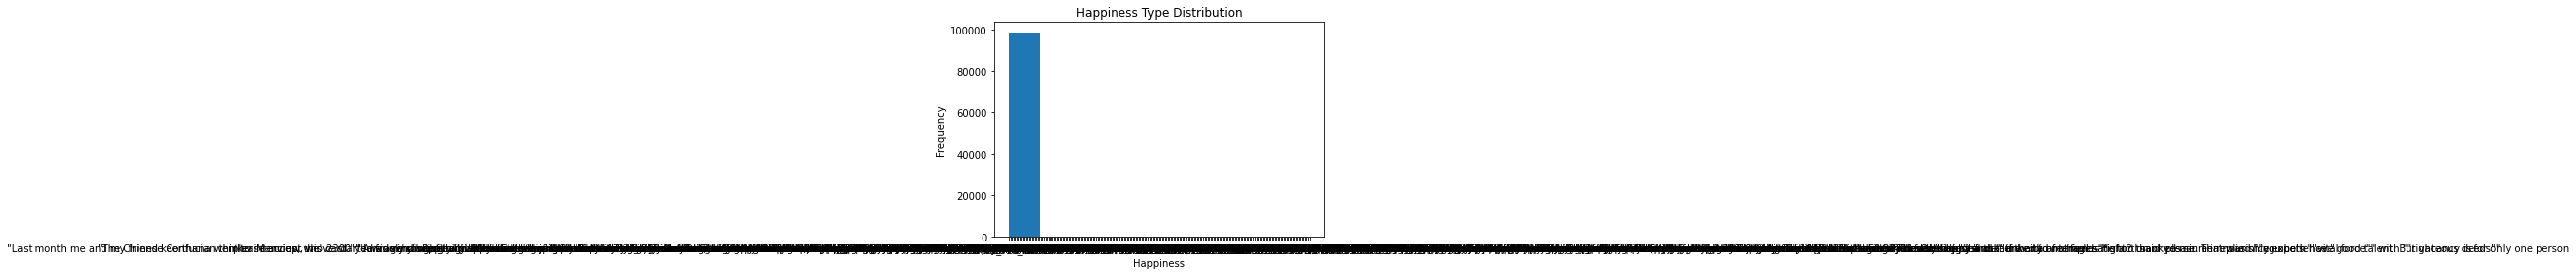

In [10]:
# Predicted values as happiness
happy_grouped_df = df_happy.groupBy('predicted_category')
happy_df = happy_grouped_df.count()
happy_df.show()

happy_data = df_happy.filter(df_happy['predicted_category'].isNotNull() & (df_happy['predicted_category'] != '')).select('predicted_category').rdd.flatMap(lambda x: x).collect()

plt.hist(happy_data)

plt.xlabel('Happiness')
plt.ylabel('Frequency')
plt.title('Happiness Type Distribution')

plt.show()

In [11]:
# Data quality verification

# Import required library
from pyspark.sql.functions import col, isnan, when, count

# Count the rows with null values in the entire DataFrame
count_null_rows = df_demog.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_demog.columns]).collect()[0]

print("Count of rows with null values in the DataFrame:")
for column in df_demog.columns:
    print(f"{column}: {count_null_rows[column]}")

Count of rows with null values in the DataFrame:
wid: 0
age: 35
country: 73
gender: 32
marital: 57
parenthood: 31


In [12]:
#Age

# Filter out non-numeric responses in the 'age' column
non_numeric_age_count = df_demog.filter(~col('age').cast('int').isNotNull()).count()

print(f"Count of non-numeric responses in the 'age' column: {non_numeric_age_count}")

non_numeric_age_df = df_demog.filter(~col('age').cast('int').isNotNull())
non_numeric_age_df.show()


Count of non-numeric responses in the 'age' column: 38
+----+-----------------+-------+------+--------+----------+
| wid|              age|country|gender| marital|parenthood|
+----+-----------------+-------+------+--------+----------+
| 317|prefer not to say|    USA|     m|  single|         n|
|3655|             null|    USA|     m|  single|         n|
|3897|             null|    USA|     f|    null|      null|
|5109|             null|   null|  null|    null|      null|
|5399|             null|    THA|     f|    null|      null|
|5489|             null|   null|     m|    null|      null|
|5528|             null|    USA|     f|  single|         n|
|5699|             null|    USA|  null|    null|      null|
|5896|             null|   null|  null|    null|      null|
|5915|             null|    USA|     f|divorced|         y|
|6138|             null|    USA|     m|  single|         n|
|6609|             null|    USA|     m|  single|         y|
|7007|             null|    USA|     m|    nu